In [123]:
from binance.client import Client
from itertools import product
import pandas as pd
import numpy as np
import talib

In [2]:
api_key = "8AiGAyxlhYQaRpE1s7097hx5sZ12Ogtr8ir9DsyztaD5j24LrI0fEoToDzCI5lle"
api_secret = "VhudTs0HsBVFNdSTghmqfCjUuIXF6rFiXIfROxHIaM71TGgib7NeZ5aOsJUHjI9f"

In [3]:
client = Client(api_key=api_key, api_secret=api_secret)

In [4]:
def get_history(symbol, interval, start=None, end=None):
    if not start:
        start = "1900-01-01"  # Just random old time for maximum candles
    bars = client.get_historical_klines(symbol=symbol, interval=interval, start_str=start, end_str=end, limit=1000)
    
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit="ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "Quote Asset Volume", "Number Of Trades", "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace=True)

    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors="coerce")
    return df

In [24]:
df = get_history("BTCUSDT", "1h", "10-01-01")
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-11-12 10:00:00,16864.46,16977.45,16807.13,16843.88,9386.816780
2022-11-12 11:00:00,16842.66,16887.51,16790.30,16866.92,5794.823020
2022-11-12 12:00:00,16866.46,16918.29,16809.83,16862.99,6102.631120


In [25]:
df.to_csv("test.csv")

In [26]:
df = pd.read_csv("test.csv", parse_dates=["Date"], index_col="Date")
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-11-12 10:00:00,16864.46,16977.45,16807.13,16843.88,9386.816780
2022-11-12 11:00:00,16842.66,16887.51,16790.30,16866.92,5794.823020
2022-11-12 12:00:00,16866.46,16918.29,16809.83,16862.99,6102.631120


## talib.SMA() == df.rolling()

In [45]:
# df["rsi"] = talib.RSI(df.Close, 14)
# df["sma1"] = talib.SMA(df.Close, 7)  # Best values for sma crossover strategy
# df["sma2"] = talib.SMA(df.Close, 20)
# df["24max"] = df.High.rolling(24).max()  # 24 hour max price
# df["365max"] = df.High.rolling(24*365).max()


# First candle to make a new 24h high, above med sma (Didn't implement yet), and rsi breaks through 50 after being below for long (lets say 10h).
# Sell loss on either rsi drops to 40, or price below sma 25 (med sma)
df["rsi"] = talib.RSI(df.Close, 14)
df["24max"] = df.High.rolling(20).max()  # 20 hour max price
df["low3"] = df.Low.rolling(3).min()
df["sma_med"] = talib.SMA(df.Close, 25)
df["rsi_max10"] = df.rsi.rolling(10).max()  # 10 hour max rsi

df

,Open,High,Low,Close,Volume,rsi,24max,sma_med,rsi_max10,low3
Date,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,NaN,NaN,NaN,NaN,4261.32
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,NaN,NaN,NaN,NaN,4287.41
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,NaN,NaN,NaN,NaN,4287.41
...,...,...,...,...,...,...,...,...,...,...
2022-11-12 10:00:00,16864.46,16977.45,16807.13,16843.88,9386.816780,45.517525,17148.96,16929.1332,46.294905,16727.13
2022-11-12 11:00:00,16842.66,16887.51,16790.30,16866.92,5794.823020,46.623939,17148.96,16910.3444,46.623939,16790.30
2022-11-12 12:00:00,16866.46,16918.29,16809.83,16862.99,6102.631120,46.450659,17148.96,16890.8360,46.623939,16790.30


In [9]:
tmp = pd.DataFrame(index=df.index)
tmp["patterns"] = 0
tmp["pos"] = 0
tmp["neg"] = 0
tmp["tmp"] = 0
functions = (talib.CDL2CROWS, talib.CDL3BLACKCROWS, talib.CDL3INSIDE, talib.CDL3LINESTRIKE, talib.CDL3OUTSIDE, talib.CDL3STARSINSOUTH, talib.CDL3WHITESOLDIERS, talib.CDLABANDONEDBABY, talib.CDLADVANCEBLOCK, talib.CDLBELTHOLD, talib.CDLBREAKAWAY, talib.CDLCLOSINGMARUBOZU, talib.CDLCONCEALBABYSWALL, talib.CDLCOUNTERATTACK, talib.CDLDARKCLOUDCOVER, talib.CDLDOJI, talib.CDLDOJISTAR, talib.CDLDRAGONFLYDOJI, talib.CDLENGULFING, talib.CDLEVENINGDOJISTAR, talib.CDLEVENINGSTAR, talib.CDLGAPSIDESIDEWHITE, talib.CDLGRAVESTONEDOJI, talib.CDLHAMMER, talib.CDLHANGINGMAN, talib.CDLHARAMI, talib.CDLHARAMICROSS, talib.CDLHIGHWAVE, talib.CDLHIKKAKE, talib.CDLHIKKAKEMOD, talib.CDLHOMINGPIGEON, talib.CDLIDENTICAL3CROWS, talib.CDLINNECK, talib.CDLINVERTEDHAMMER, talib.CDLKICKING, talib.CDLKICKINGBYLENGTH, talib.CDLLADDERBOTTOM, talib.CDLLONGLEGGEDDOJI, talib.CDLLONGLINE, talib.CDLMARUBOZU, talib.CDLMATCHINGLOW, talib.CDLMATHOLD, talib.CDLMORNINGDOJISTAR, talib.CDLMORNINGSTAR, talib.CDLONNECK, talib.CDLPIERCING, talib.CDLRICKSHAWMAN, talib.CDLRISEFALL3METHODS, talib.CDLSEPARATINGLINES, talib.CDLSHOOTINGSTAR, talib.CDLSHORTLINE, talib.CDLSPINNINGTOP, talib.CDLSTALLEDPATTERN, talib.CDLSTICKSANDWICH, talib.CDLTAKURI, talib.CDLTASUKIGAP, talib.CDLTHRUSTING, talib.CDLTRISTAR, talib.CDLUNIQUE3RIVER, talib.CDLUPSIDEGAP2CROWS, talib.CDLXSIDEGAP3METHODS)
for function in functions:
    tmp["tmp"] = function(df.Open, df.High, df.Low, df.Close)
    tmp["patterns"] = tmp["patterns"] + tmp["tmp"]
    tmp.loc[tmp["tmp"] > 0, "pos"] += 1
    tmp.loc[tmp["tmp"] < 0, "neg"] -= 1
df["patterns"] = tmp["patterns"]
tmp

,patterns,pos,neg,tmp
Date,,,,
2017-08-17 04:00:00,0,0,0,0
2017-08-17 05:00:00,0,0,0,0
2017-08-17 06:00:00,0,0,0,0
2017-08-17 07:00:00,100,1,0,0
2017-08-17 08:00:00,100,1,0,0
...,...,...,...,...
2022-11-12 09:00:00,200,2,0,0
2022-11-12 10:00:00,-200,0,-2,0
2022-11-12 11:00:00,200,2,0,0


In [69]:
bcond1 = df.High > df["24max"].shift(1)  # New high
bcond1_1 = bcond1.rolling(3).max() == 1  # Broke new high in the last 3 hours
bcond2 = (df["rsi_max10"].shift(1) < 50) & (df["rsi"] > 50) # Rsi above 10 rsi length
bcond2_1 = bcond2.rolling(3).max() == 1  # Broke above 50 in the last 3 hours

buy_cond = bcond1_1 & bcond2_1

scond1 = df.rsi < 40 
scond2 = df.Close < df["sma_med"]

sell_cond = scond1 | scond2

False    23950
True     21846
dtype: int64

In [98]:
df["pos"] = np.nan
df.loc[buy_cond, "pos"] = 1
df.loc[sell_cond, "pos"] = 0
df["pos"].fillna(method="ffill", inplace=True)
df["pos"].tail(40)
df["pos"].value_counts()

0.0    42174
1.0     3598
Name: pos, dtype: int64

In [119]:
class strategy_tester():
    def __init__(self, filepath, units=1, tc=0.1):
        self.filepath = filepath
        self.units = units
        self.tc = tc

    def get_data(self):
        self.data = pd.read_csv("test.csv", parse_dates=["Date"], index_col="Date")
        
    def prepare_data(self, rsi, long_max, shrt_low, sma_med, rsi_max):
        """
        rsi - rsi period (defualt 14)
        long_max - max price of the last x candles (20)
        short_low - lowest price of the last x candles (3)
        sma_med - medium sma (25)
        rsi_max - max rsi of the last x days (10)
        """
#         df = self.data[["close", "Volume USD", "High"]].copy()
#         df.columns = ["Close", "Volume"]
        df = self.data
        df["returns"] = np.log(df.Close.div(df.Close.shift(1)))
        df["rsi"] = talib.RSI(df.Close, rsi)
        df["24max"] = df.High.rolling(long_max).max()  # 20 hour max price
        df["low3"] = df.Low.rolling(shrt_low).min()
        df["sma_med"] = talib.SMA(df.Close, sma_med)
        df["rsi_max10"] = df.rsi.rolling(rsi_max).max()  # 10 hour max rsi
        
        bcond1 = df.High > df["24max"].shift(1)  # New high
        bcond1_1 = bcond1.rolling(3).max() == 1  # Broke new high in the last 3 hours
        bcond2 = (df["rsi_max10"].shift(1) < 50) & (df["rsi"] > 50) # Rsi above 10 rsi length
        bcond2_1 = bcond2.rolling(3).max() == 1  # Broke above 50 in the last 3 hours

        buy_cond = bcond1_1 & bcond2_1

        scond1 = df.rsi < 40 
        scond2 = df.Close < df["sma_med"]

        sell_cond = scond1 | scond2
      
        df["position"] = np.nan
        df.loc[buy_cond, "position"] = self.units
        df.loc[sell_cond, "position"] = 0
        df["position"].fillna(method="ffill", inplace=True)
        df["position"].tail(40)
        df["position"].value_counts()

        self.data = df
    
    def run_backtest(self):
        df = self.data.copy()
        df["strategy"] = df.returns * df.position.shift(1)
        df["trades"] = df.position.diff().fillna(0).abs()  # To calculate fees and shit
        df.strategy = df.strategy + (df.trades * self.tc)  # Calculate fees and shit
        df["creturns"] = df.returns.cumsum().apply(np.exp)
        df["cstrategy"] = df.strategy.cumsum().apply(np.exp)
        self.data = df.copy()
        
    def test_strategy(self, rsi, long_max, shrt_low, sma_med, rsi_max):
        self.get_data()
        df = self.data
        self.prepare_data(rsi, long_max, shrt_low, sma_med, rsi_max)
        self.run_backtest()
        
    def optimize_strategy(self, rsi_r, long_max_r, shrt_low_r, sma_med_r, rsi_max_r):
        self.datas = []
        performance = []
        combinations = list(product(rsi_r, long_max_r, shrt_low_r, sma_med_r, rsi_max_r))
        for comb in combinations:
            self.test_strategy(comb[0], comb[1], comb[2], comb[3], comb[4])
#             self.datas.append(self.data)
            performance.append(self.calc_creturn(self.data))
        self.results_overview =  pd.DataFrame(data=np.array(combinations), columns=["RSI", "long max", "short low", "medium sma", "RSI max"])
        self.results_overview["cstrategy"] = performance
        
    def calc_creturn(self, series):
        return float(series[["strategy"]].sum().apply(np.exp))

In [120]:
tester = strategy_tester("test.csv", units=1, tc=0)

In [133]:
tester.test_strategy(10, 20, 2, 21, 8)

In [134]:
tester.data[["returns", "strategy"]].sum().apply(np.exp)

returns     3.903972
strategy    1.171336
dtype: float64

<AxesSubplot: xlabel='Date'>

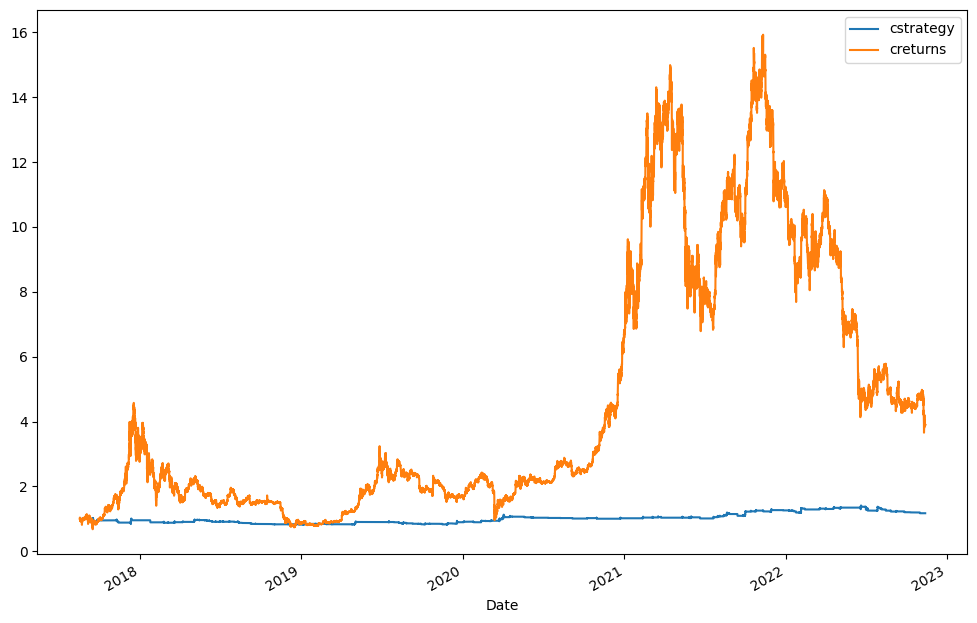

In [135]:
tester.data[["cstrategy", "creturns"]].plot(figsize=(12, 8))

In [129]:
tester.optimize_strategy(range(7, 16), range(15, 24), range(2, 5), range(20, 27) , range(8, 12))

In [130]:
tester.results_overview.nlargest(10, "cstrategy")

,RSI,long max,short low,medium sma,RSI max,cstrategy
2692,10,20,2,21,8,1.171336
2720,10,20,3,21,8,1.171336
2748,10,20,4,21,8,1.171336
2696,10,20,2,22,8,1.114980
2724,10,20,3,22,8,1.114980
2752,10,20,4,22,8,1.114980
2188,9,23,2,21,8,1.106447
2216,9,23,3,21,8,1.106447
2244,9,23,4,21,8,1.106447
1936,9,20,2,21,8,1.106179
